In [1]:
# Tratamiento de datos
# ------------------------------------------------------------------------------
import numpy as np
import pandas as pd

# Gráficos
# ------------------------------------------------------------------------------
import matplotlib.pyplot as plt
import seaborn as sns

# Modelado y evaluación
# ------------------------------------------------------------------------------
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import GridSearchCV

# Configuración warnings
# ------------------------------------------------------------------------------
import warnings
warnings.filterwarnings('once')

import datetime

In [2]:
df = pd.read_pickle("datos/5.reg_encoding_estandarizacion.pkl")
df.head()

,yr,mnth,dia_anual,holiday_num,weekday_num,workingday_num,weathersit,registered,seasons_autumn,seasons_spring,seasons_summer,seasons_winter,atemp,cnt
0,0,1,1,1,0,0,2,654,0.0,0.0,0.0,1.0,-0.680818,-1.820972
1,0,1,2,0,1,1,2,670,0.0,0.0,0.0,1.0,-0.741507,-1.916078
2,0,1,3,0,2,1,1,1229,0.0,0.0,0.0,1.0,-1.750344,-1.632827
3,0,1,4,0,3,1,1,1454,0.0,0.0,0.0,1.0,-1.610886,-1.522732
4,0,1,5,0,4,1,1,1518,0.0,0.0,0.0,1.0,-1.505615,-1.503090


In [3]:
df.dtypes

yr                category
mnth              category
dia_anual         category
holiday_num       category
weekday_num       category
workingday_num    category
weathersit        category
registered           int64
seasons_autumn    category
seasons_spring    category
seasons_summer    category
seasons_winter    category
atemp              float64
cnt                float64
dtype: object

In [4]:
#df["dteday"].astype

In [5]:
# al igual que en la regresión lineal tenemos que separar nuestro dataframe en X e y

X = df.drop("registered", axis = 1)
y = df["registered"]

In [6]:
# y dividir nuestros datos en train y test para poder evaluar la bondad de nuestro modelo

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [7]:
# creamos el objeto del modelo, al igual que hacíamos en la regresión lineal
arbol = DecisionTreeRegressor(random_state =0)

# ajustamos el modelo, igual que en la regresión lienal. 
arbol.fit(x_train, y_train)

DecisionTreeRegressor(random_state=0)

In [8]:
# max features. Como vemos, debemos poner en nuestro modelo una profudidad máxima de 4. 

max_features = np.sqrt(len(x_train.columns))
max_features

3.605551275463989

In [9]:
# max depth

print(arbol.tree_.max_depth)

16


In [10]:
# hacemos las predicciones sobre los dos set de datos el X_test y el X_train
y_pred_test_dt = arbol.predict(x_test)
y_pred_train_dt = arbol.predict(x_train)

In [11]:
def metricas(y_test, y_train, y_test_pred, y_train_pred, tipo_modelo):
    
    
    resultados = {'MAE': [mean_absolute_error(y_test, y_test_pred), mean_absolute_error(y_train, y_train_pred)],
                'MSE': [mean_squared_error(y_test, y_test_pred), mean_squared_error(y_train, y_train_pred)],
                'RMSE': [np.sqrt(mean_squared_error(y_test, y_test_pred)), np.sqrt(mean_squared_error(y_train, y_train_pred))],
                'R2':  [r2_score(y_test, y_test_pred), r2_score(y_train, y_train_pred)],
                 "set": ["test", "train"]}
    df = pd.DataFrame(resultados)
    df["modelo"] = tipo_modelo
    return df

In [12]:
# sacamos las métricas para ver si hay overfitting o unerfitting, para modificar la profundidad en función de estos resultados

dt_results1 = metricas(y_test, y_train, y_pred_test_dt, y_pred_train_dt, "Reg_est_Decission Tree I Est-Cod")
dt_results1

,MAE,MSE,RMSE,R2,set,modelo
0,202.561644,94126.09589,306.799765,0.956394,test,Reg_est_Decission Tree I Est-Cod
1,0.000000,0.00000,0.000000,1.000000,train,Reg_est_Decission Tree I Est-Cod


In [13]:
df.shape

(730, 14)

Overfitting

In [14]:
# lo primero que tenemos que hacer es definir un diccionario con los hiperparámetros que queremos modificar y los valores que queremos 

param = {"max_depth": [2,3,4], # teniendo en cuenta que teníamos overfitting tendremos que reducir la profundidad del modelo, la nuestra anterior era de 17. Bajaremos mucho este valor ya que teníamos un overfitting muy claro
        "max_features": [1,2,3,4],# calculamos en celdas anteriores, probaremos a hacer el modelo como una variable, 2, 3 y 4. Ponemos como límite el 4 ya que es el resultado de la raiz cuadrada. 
        # estos dos hiperparámetros son más difíciles de definir, pero usualmente se suelen elegir los siguientes valores
        "min_samples_split": [10, 50, 100],
        "min_samples_leaf": [10,50,100]} 

In [15]:
# una vez creado el diccionario iniciaremos el modelo con GridSearch

gs = GridSearchCV(
            estimator=DecisionTreeRegressor(), # tipo de modelo que queremos hacer
            param_grid= param, # que hiperparámetros queremos que testee
            cv=10, # crossvalidation que aprendimos en la lección de regresión lineal intro. 
            verbose=-1, # para que no nos printee ningún mensaje en pantalla
            return_train_score = True, # para que nos devuelva el valor de las métricas de set de datos de entrenamiento
            scoring="neg_mean_squared_error") # la métrica que queremos que nos devuelva

In [16]:
# ajustamos el modelo que acabamos de definir en el GridSearch

gs.fit(x_train, y_train)

GridSearchCV(cv=10, estimator=DecisionTreeRegressor(),
             param_grid={'max_depth': [2, 3, 4], 'max_features': [1, 2, 3, 4],
                         'min_samples_leaf': [10, 50, 100],
                         'min_samples_split': [10, 50, 100]},
             return_train_score=True, scoring='neg_mean_squared_error',
             verbose=-1)

In [17]:
# este método nos esta diciendo que el mejor modelo es aquel que tiene una profundidad de 6, que usa 4 variables predictoras para construir el modelo y que tiene  un min_samples_leaf y un min_samples_split de 10. 
mejor_modelo = gs.best_estimator_
mejor_modelo

DecisionTreeRegressor(max_depth=4, max_features=4, min_samples_leaf=10,
                      min_samples_split=50)

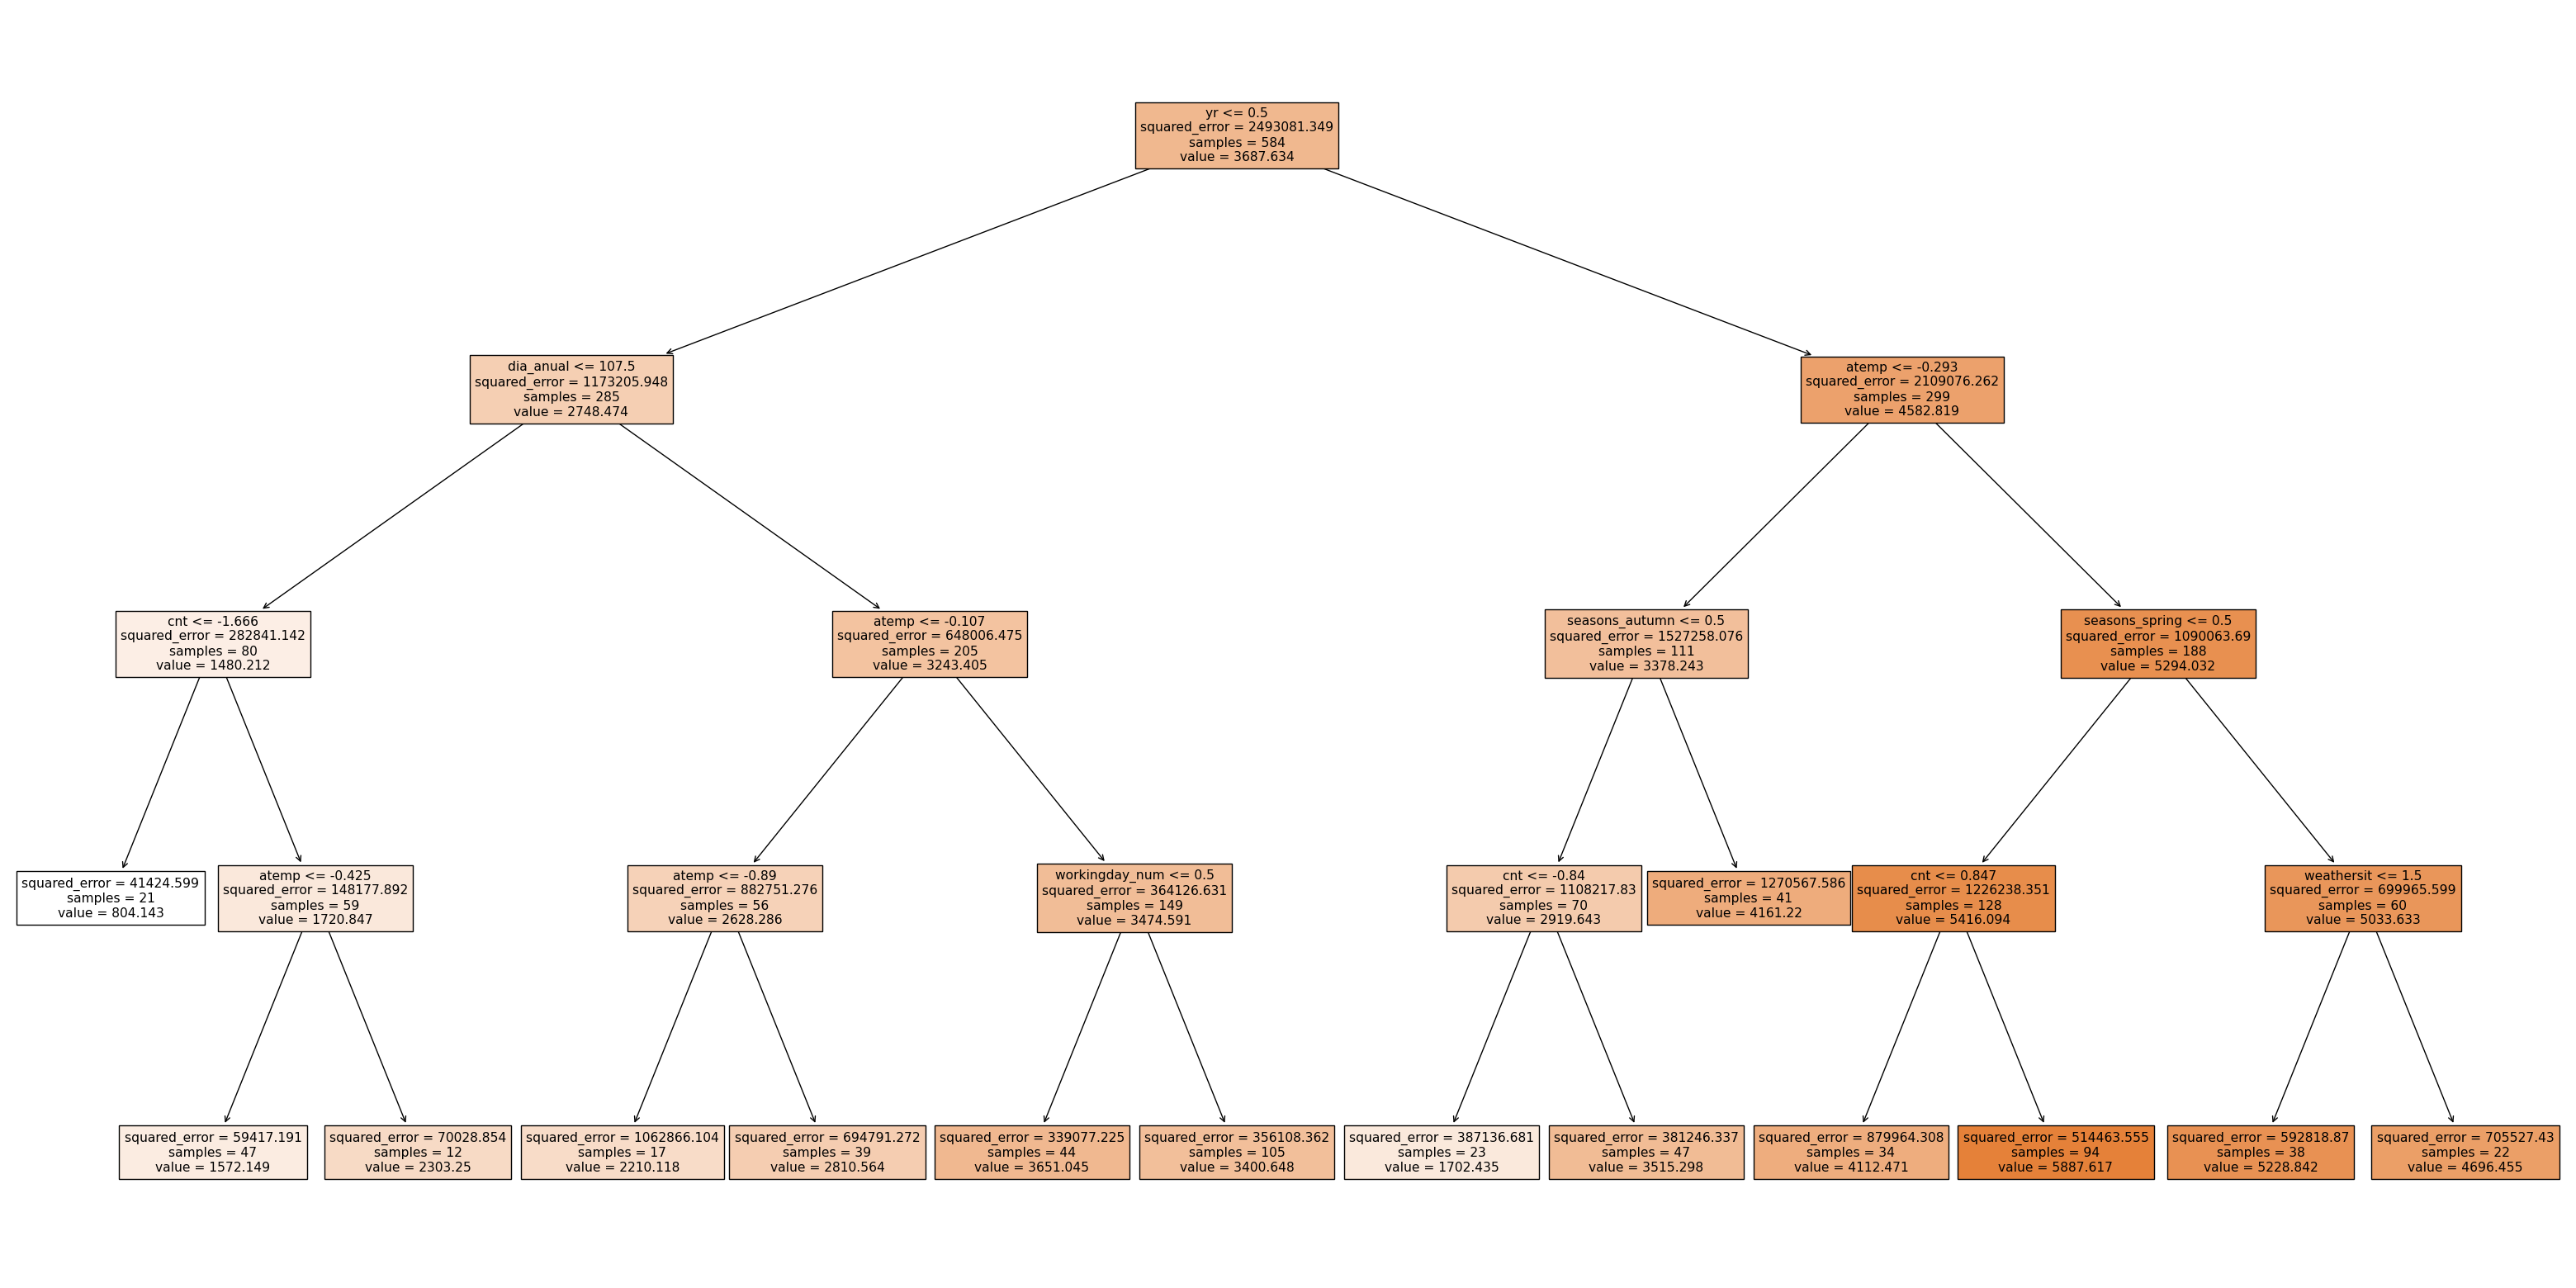

In [18]:
# veamos ahora que pinta tiene nuestro árbol


fig = plt.figure(figsize=(40, 20))
tree.plot_tree(mejor_modelo, feature_names=x_train.columns, filled=True);

In [19]:
y_pred_test_dt2 = mejor_modelo.predict(x_test)
y_pred_train_dt2 = mejor_modelo.predict(x_train)

In [20]:
dt_results2 = metricas(y_test, y_train, y_pred_test_dt2, y_pred_train_dt2, "Reg_est_Decision tree II Est-Cod")
dt_results2

,MAE,MSE,RMSE,R2,set,modelo
0,526.958790,486331.406888,697.374653,0.774698,test,Reg_est_Decision tree II Est-Cod
1,538.241508,508942.300858,713.401921,0.795858,train,Reg_est_Decision tree II Est-Cod


In [21]:
df.head(2)

,yr,mnth,dia_anual,holiday_num,weekday_num,workingday_num,weathersit,registered,seasons_autumn,seasons_spring,seasons_summer,seasons_winter,atemp,cnt
0,0,1,1,1,0,0,2,654,0.0,0.0,0.0,1.0,-0.680818,-1.820972
1,0,1,2,0,1,1,2,670,0.0,0.0,0.0,1.0,-0.741507,-1.916078


In [22]:
# vamos  a juntar los dataframes de los resultados de los modelos para poder compararlos mejor

df_decision_results = pd.concat([dt_results1, dt_results2], axis = 0).reset_index(drop=True)
df_decision_results

,MAE,MSE,RMSE,R2,set,modelo
0,202.561644,94126.095890,306.799765,0.956394,test,Reg_est_Decission Tree I Est-Cod
1,0.000000,0.000000,0.000000,1.000000,train,Reg_est_Decission Tree I Est-Cod
2,526.958790,486331.406888,697.374653,0.774698,test,Reg_est_Decision tree II Est-Cod
3,538.241508,508942.300858,713.401921,0.795858,train,Reg_est_Decision tree II Est-Cod


In [27]:
df_decision_results.style.background_gradient()

,MAE,MSE,RMSE,R2,set,modelo
0,202.561644,94126.095890,306.799765,0.956394,test,Reg_est_Decission Tree I Est-Cod
1,0.000000,0.000000,0.000000,1.000000,train,Reg_est_Decission Tree I Est-Cod
2,526.958790,486331.406888,697.374653,0.774698,test,Reg_est_Decision tree II Est-Cod
3,538.241508,508942.300858,713.401921,0.795858,train,Reg_est_Decision tree II Est-Cod


In [26]:
df_DT1 = pd.read_csv("datos/6.reg_resultados_1_cod.csv", index_col = 0)
df_DT1

,MAE,MSE,RMSE,R2,set,modelo
0,214.321918,101141.787671,318.027967,0.953144,test,Reg_Cod_Decission Tree I
1,0.000000,0.000000,0.000000,1.000000,train,Reg_Cod_Decission Tree I
2,403.047749,264899.404086,514.683790,0.877280,test,Reg_Cod_Decision tree II
3,387.159792,244561.022740,494.531114,0.901904,train,Reg_Cod_Decision tree II


In [31]:
df_DT1_DT2_results = pd.concat([df_decision_results, df_DT1], axis = 0).reset_index(drop=True)
df_DT1_DT2_results

,MAE,MSE,RMSE,R2,set,modelo
0,202.561644,94126.095890,306.799765,0.956394,test,Reg_est_Decission Tree I Est-Cod
1,0.000000,0.000000,0.000000,1.000000,train,Reg_est_Decission Tree I Est-Cod
2,526.958790,486331.406888,697.374653,0.774698,test,Reg_est_Decision tree II Est-Cod
3,538.241508,508942.300858,713.401921,0.795858,train,Reg_est_Decision tree II Est-Cod
4,214.321918,101141.787671,318.027967,0.953144,test,Reg_Cod_Decission Tree I
5,0.000000,0.000000,0.000000,1.000000,train,Reg_Cod_Decission Tree I
6,403.047749,264899.404086,514.683790,0.877280,test,Reg_Cod_Decision tree II
7,387.159792,244561.022740,494.531114,0.901904,train,Reg_Cod_Decision tree II


In [32]:
df_DT1_DT2_results.drop([0,1,4,5], axis=0, inplace=True)

In [33]:
df_DT1_DT2_results.head()

,MAE,MSE,RMSE,R2,set,modelo
2,526.958790,486331.406888,697.374653,0.774698,test,Reg_est_Decision tree II Est-Cod
3,538.241508,508942.300858,713.401921,0.795858,train,Reg_est_Decision tree II Est-Cod
6,403.047749,264899.404086,514.683790,0.877280,test,Reg_Cod_Decision tree II
7,387.159792,244561.022740,494.531114,0.901904,train,Reg_Cod_Decision tree II


In [34]:
df_DT1_DT2_results.style.background_gradient()

,MAE,MSE,RMSE,R2,set,modelo
2,526.958790,486331.406888,697.374653,0.774698,test,Reg_est_Decision tree II Est-Cod
3,538.241508,508942.300858,713.401921,0.795858,train,Reg_est_Decision tree II Est-Cod
6,403.047749,264899.404086,514.683790,0.877280,test,Reg_Cod_Decision tree II
7,387.159792,244561.022740,494.531114,0.901904,train,Reg_Cod_Decision tree II


In [35]:
df_DT1_DT2_results.to_csv("datos/6.reg_resultados_2_cod_est.csv")